In [77]:
# M2 Q1 – Spatial Movement Styles
# Erica

# Research Question:
# Do pet cats exhibit distinct spatial movement styles at the individual level, independent of time?

In [78]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [10]:
# pulls dataset
url1 = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/refs/heads/main/data/2023/2023-01-31/cats_uk.csv"
cats_uk = pd.read_csv(url1)
url2 = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/refs/heads/main/data/2023/2023-01-31/cats_uk_reference.csv"
cats_uk_ref = pd.read_csv(url2)

In [46]:
cats_uk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18215 entries, 0 to 18214
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   tag_id                    18215 non-null  object 
 1   event_id                  18215 non-null  int64  
 2   visible                   18215 non-null  bool   
 3   timestamp                 18215 non-null  object 
 4   location_long             18215 non-null  float64
 5   location_lat              18215 non-null  float64
 6   ground_speed              18215 non-null  int64  
 7   height_above_ellipsoid    18215 non-null  float64
 8   algorithm_marked_outlier  18215 non-null  bool   
 9   manually_marked_outlier   18215 non-null  bool   
 10  study_name                18215 non-null  object 
 11  hrs_indoors_x             18215 non-null  float64
 12  indoor_access             18215 non-null  object 
 13  hrs_indoors_y             18215 non-null  float64
 14  hrs_in

In [47]:
cats_uk_ref.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   tag_id                         101 non-null    object 
 1   animal_id                      101 non-null    object 
 2   animal_taxon                   101 non-null    object 
 3   deploy_on_date                 101 non-null    object 
 4   deploy_off_date                101 non-null    object 
 5   hunt                           92 non-null     object 
 6   prey_p_month                   101 non-null    float64
 7   animal_reproductive_condition  98 non-null     object 
 8   animal_sex                     101 non-null    object 
 9   hrs_indoors                    101 non-null    float64
 10  n_cats                         101 non-null    int64  
 11  food_dry                       101 non-null    bool   
 12  food_wet                       101 non-null    boo

# **EDA from M1**

Question: Do cats exhibit distinct styles of spatial movement, such as highly localized routines versus exploratory roaming, and how sharply separated are these behaviors across individuals?

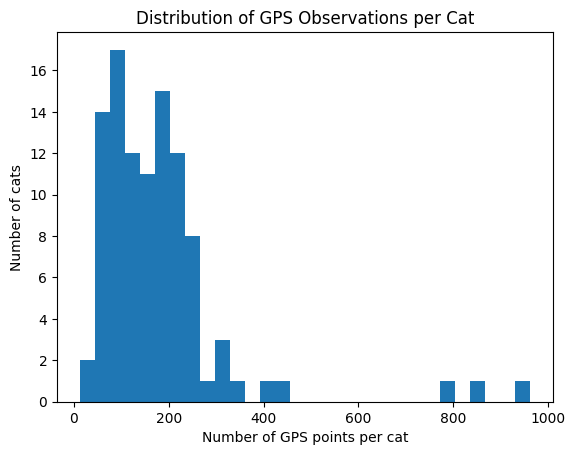

In [6]:
points_per_cat = cats_uk.groupby("tag_id").size()

plt.figure()
plt.hist(points_per_cat, bins=30)
plt.xlabel("Number of GPS points per cat")
plt.ylabel("Number of cats")
plt.title("Distribution of GPS Observations per Cat")
plt.show()

Insight: The dataset is not a uniform sample of movement behavior but a collection of uneven individual movement histories. There are three cats who are outliers with many more GPS points (>800). Because spatial extent and dispersion are estimated from observed locations, cats with very few GPS points may have artificially small or noisy summaries.


Question: Do cats differ substantially in indoor time, suggesting heterogeneous constraints?

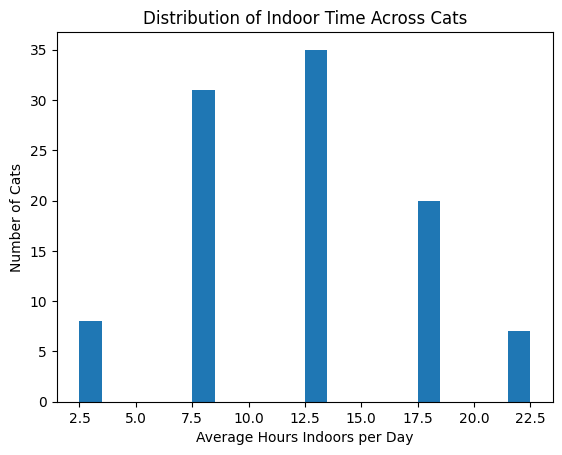

In [ ]:
plt.figure()
plt.hist(cats_uk_ref["hrs_indoors"].dropna(), bins=20)
plt.xlabel("Average Hours Indoors per Day")
plt.ylabel("Number of Cats")
plt.title("Distribution of Indoor Time Across Cats")
plt.show()

Insight: Cats subject to similar constraints exhibit diverse spatial usage patterns and movement styles, suggesting that simple household rules do not fully determine behavioral outcomes

# **EDA and Preprocessing Updates (M2)**

#### M2 Update: Checking stability of spatial summaries

Given the large imbalance in GPS observations across cats,
we examine the distribution of tracking density to assess whether very sparse records may lead to unstable spatial summaries.


In [7]:
# M2 update: flag cats with very sparse GPS observations
points_per_cat = cats_uk.groupby("tag_id").size()

points_per_cat.describe()

,0
count,101.000000
mean,180.346535
std,146.280582
min,12.000000
25%,100.000000
50%,155.000000
75%,214.000000
max,963.000000


##### **Insight:** GPS observation counts vary widely across cats, ranging from as few as 12 to nearly 1,000 points. This level of imbalance suggests that spatial summaries for cats with very sparse tracking may be unstable, motivating the need to assess tracking density before comparing spatial movement patterns across individuals.


### M2 Update: Sharp separation vs continuous spectrum

We use bounding box area as a simple, scale-free proxy for spatial extent, acknowledging that it is sensitive to outliers and does not capture path structure. Despite these limitations, it provides a consistent, individual-level summary suitable for comparative analysis across cats.



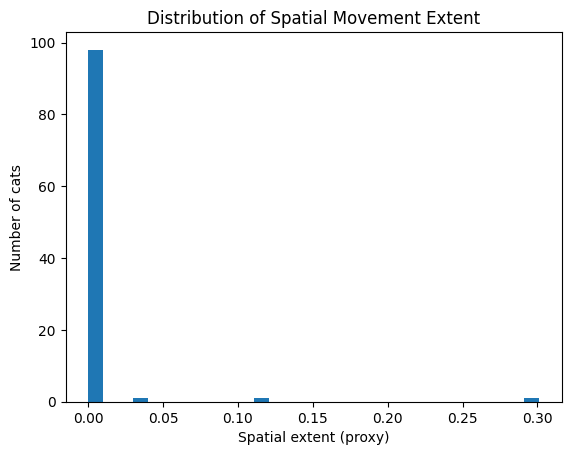

In [88]:
# Example: spatial extent proxy (bounding box area)
spatial_extent = (
    cats_uk
    .groupby("tag_id")
    [['location_long', 'location_lat']] # Explicitly select non-grouping columns
    .apply(
        lambda x:
        (x["location_long"].max() - x["location_long"].min()) *
        (x["location_lat"].max() - x["location_lat"].min())
    )
)

plt.hist(spatial_extent, bins=30)
plt.xlabel("Spatial extent (proxy)")
plt.ylabel("Number of cats")
plt.title("Distribution of Spatial Movement Extent")
plt.show()

##### **Insight:** The distribution of spatial extent is highly skewed, with most cats occupying relatively small spatial ranges and a small number of cats exhibiting much larger movement extents. This pattern is consistent with the possibility that movement styles lie along a continuum.

### Note on scope and exclusions
Cats with very few GPS observations were excluded to improve the stability of spatial summaries. Although timestamps are available in the raw data, Question 1 focuses on aggregate, individual-level spatial movement patterns, rather than time-ordered trajectories. A minimum observation threshold was used as a conservative cutoff to balance estimation stability with sample retention, rather than as a theoretically meaningful boundary.


### Research Question : Do individual cats’ spatial movement patterns exhibit evidence of distinct clustering,or do they lie along a continuous spectrum when controlling for indoor access?

# **Analysis & Experiments**

This section applies unsupervised methods to examine whether spatial movement styles among pet cats form distinct groups or lie along a continuous spectrum, even after accounting for similar environmental constraints.

**So what is environmental constraints?**

To focus on behavioral differences in spatial movement rather than
differences in access to space, the primary analysis is restricted
to cats classified as mostly indoor. This allows for a more
controlled comparison of spatial movement styles under similar
environmental constraints.

Cats with mixed or mostly outdoor access are not included in the
main clustering analysis and are discussed separately in the
Appendix for robustness. This restriction is intended to reduce confounding from access to space, not to make claims about outdoor or mixed-access cats.


### Method 1: K-Prototypes Clustering

This method is used to examine whether cats can be grouped into distinct spatial movement styles based on a combination of numerical spatial features and categorical contextual attributes. Since the dataset contains a mix of numerical spatial summaries (e.g., spatial extent proxies) and categorical attributes (e.g., indoor constraints). K-prototypes is appropriate because it extends k-means by jointly handling mixed data types without requiring ad hoc encoding that could distort distance calculations. I include indoor access and study site to avoid clustering driven purely by spatial scale, ensuring that inferred movement styles are not artifacts of
environmental access differences.


In [82]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from kmodes.kprototypes import KPrototypes

# 1) Build individual-level spatial features
  # (While both features capture spatial spread, extent reflects range size, whereas dispersion captures concentration around a central tendency.While both features capture spatial spread, extent reflects range size, whereas dispersion captures concentration around a central tendency.)
def make_spatial_features(df):
    lon = df["location_long"].values
    lat = df["location_lat"].values
    #(1) extent_bbox
    extent = (lon.max() - lon.min()) * (lat.max() - lat.min())

    lon_c = lon.mean()
    lat_c = lat.mean()
    #(2) dispersion_centroid (-> If it’s larger, the locations are more spread out from the center)
    dispersion = np.mean((lon - lon_c) ** 2 + (lat - lat_c) ** 2)

    return pd.Series({
        "n_points": len(df),
        "extent_bbox": extent,
        "dispersion_centroid": dispersion
    })

spatial_feat = (
    cats_uk
    .groupby("tag_id", sort=False)
    .apply(lambda g: make_spatial_features(g), include_groups=False)
    .reset_index()
)

In [76]:
# 2) Merge reference table (cat-level attributes)
cats_feat = spatial_feat.merge(cats_uk_ref, on="tag_id", how="left")

In [ ]:
# 3) Create indoor_access categories from hrs_indoors [environment constraints]
cats_feat["indoor_access"] = cats_feat["hrs_indoors"].apply(
    lambda x: "Mostly indoor" if x >= 12 else ("Mostly outdoor" if x < 6 else "Mixed")
)

In [65]:
# 4) Filter cats with enough points (Remove cats with fewer than 50 GPS observations)
cats_feat = cats_feat[cats_feat["n_points"] >= 50].copy()

# 5) Log-transform spatial features
cats_feat["log_extent"] = np.log1p(cats_feat["extent_bbox"])
cats_feat["log_dispersion"] = np.log1p(cats_feat["dispersion_centroid"])

num_cols = ["log_extent", "log_dispersion"]
cat_cols = ["indoor_access", "study_site", "animal_sex"]

In [66]:
# 6) Clean categorical values (handle missing)
for c in cat_cols:
    if c in cats_feat.columns:
        cats_feat[c] = cats_feat[c].astype("object")
        cats_feat[c] = cats_feat[c].where(cats_feat[c].notna(), "Missing").astype(str)

In [69]:
# 7) Build mixed matrix for K-Prototypes
X_num = StandardScaler().fit_transform(cats_feat[num_cols].values)

X_cat_raw = cats_feat[cat_cols].values
X_cat = OrdinalEncoder().fit_transform(X_cat_raw)

X_kproto = np.hstack([X_num, X_cat])
categorical_idx = list(range(X_num.shape[1], X_num.shape[1] + X_cat.shape[1]))

In [71]:
# 8) Fit K-Prototypes
kproto = KPrototypes(n_clusters=2, init="Cao", n_init=20, random_state=42)
clusters = kproto.fit_predict(X_kproto, categorical=categorical_idx)
cats_feat["cluster"] = clusters

In [73]:
# Numeric means
num_summary = (
    cats_feat
    .groupby("cluster")[num_cols + ["n_points"]]
    .mean()
)

# Indoor access composition (row %)
indoor_comp = (
    pd.crosstab(
        cats_feat["cluster"],
        cats_feat["indoor_access"],
        normalize="index"
    )
)

# Rename columns to make meaning explicit
indoor_comp = indoor_comp.add_prefix("pct_")

# Combine into one table
cluster_summary = num_summary.join(indoor_comp)

cluster_summary


,log_extent,log_dispersion,n_points,pct_Mixed,pct_Mostly indoor,pct_Mostly outdoor
cluster,,,,,,
0,0.001765,0.000018,184.072165,0.309278,0.608247,0.082474
1,0.263232,0.002536,261.000000,1.000000,0.000000,0.000000


Separation vs Continuum Diagnostics

While clustering provides a useful exploratory lens rather than a definitive partition of behavioral types. Visual inspection of spatial extent and dispersion distributions shows heavy right skew and gradual transitions rather than clear gaps, suggesting that movement behaviors lie along a continuum rather than forming sharply separated categories.
